In [1]:
import numpy as np
import pandas as pd
import scipy.spatial
from pixell import utils, enmap, enplot, curvedsky, reproject, fft
from scipy.interpolate import interp1d
import os
from orphics import sehgal
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ycent = shape[0] // 2
ydelta = int(10*utils.degree/(0.5*utils.arcmin))
ymin, ymax = ycent-ydelta, ycent+ydelta
template = enmap.zeros(shape,wcs)
shape, wcs = template.geometry
areamap = enmap.pixsizemap(shape, wcs)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
ntot 49018754 nhi 1900454 nlo 47118300
359.9945068359375 0.0 89.88578658247164 -89.88578658247167


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


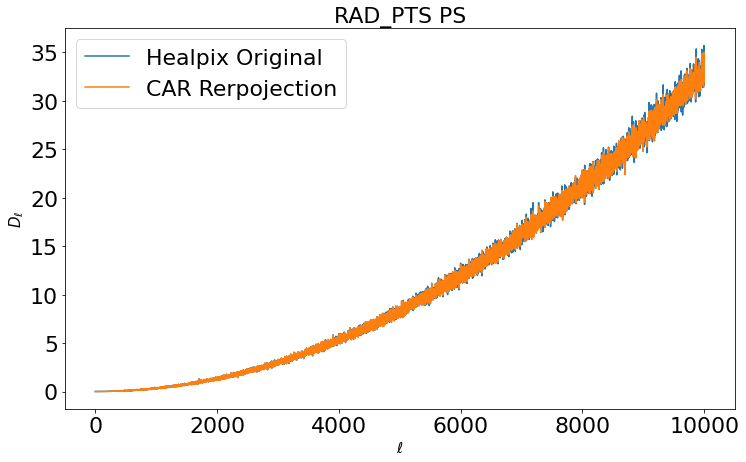

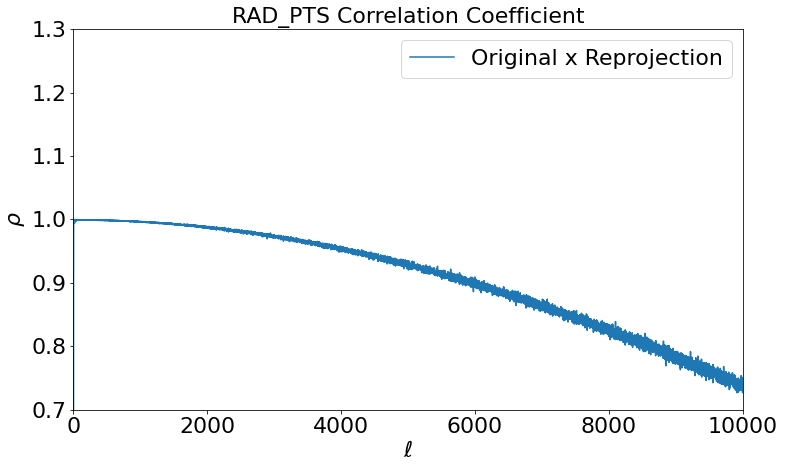

Reprejecton No Beam


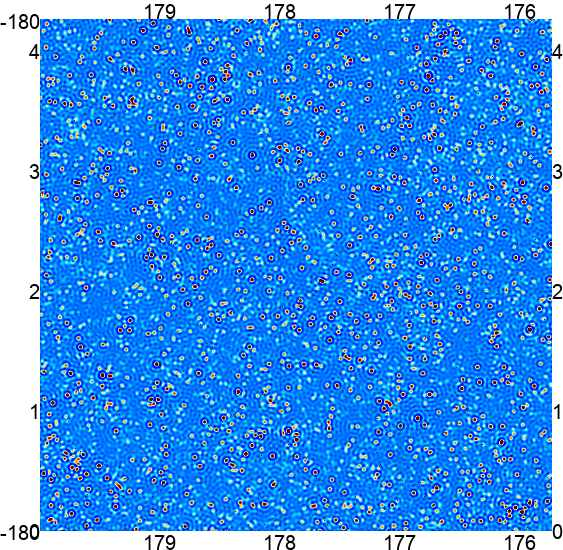

Reprojection 0.9 arcmin beam


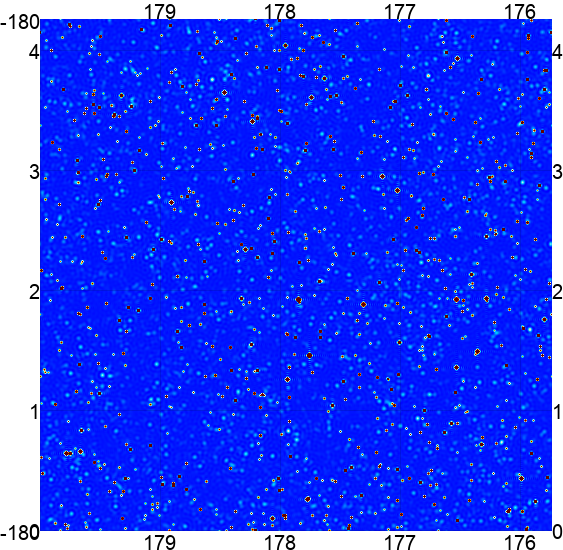

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
ntot 802594495 nhi 1784 nlo 802592711
359.9505615234375 0.04943847656249999 89.99428933006672 -89.99428933006672


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


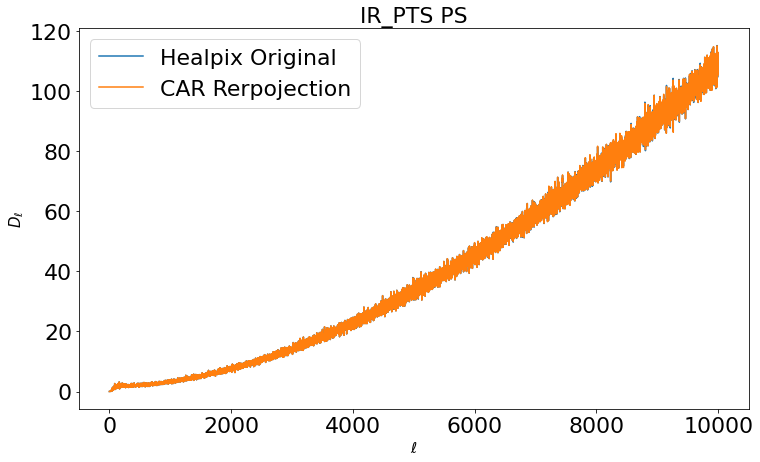

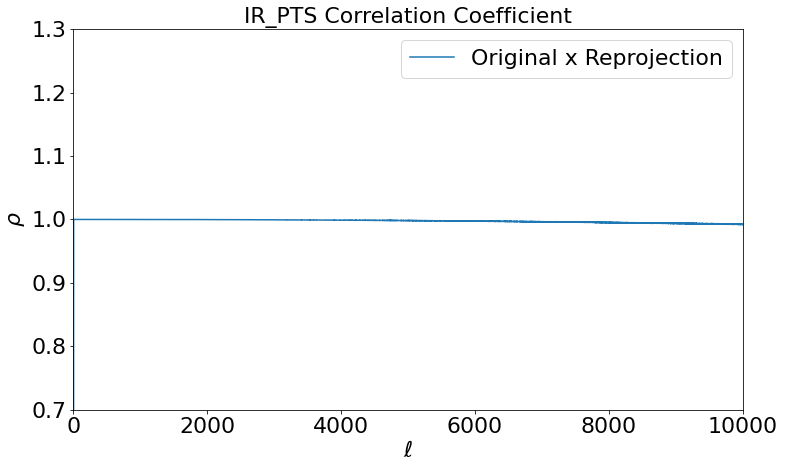

Reprejecton No Beam


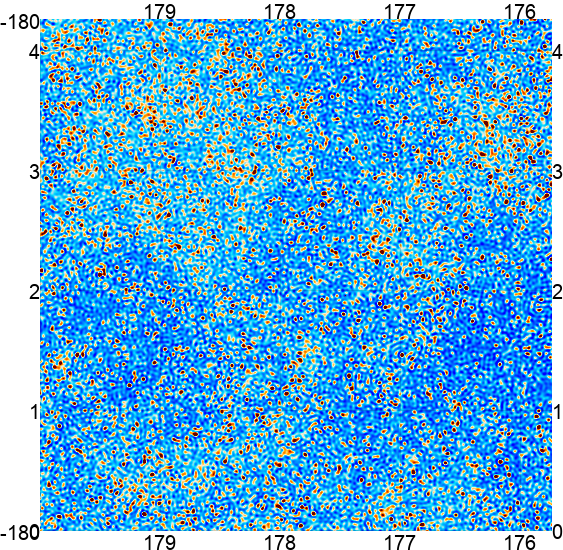

Reprojection 0.9 arcmin beam


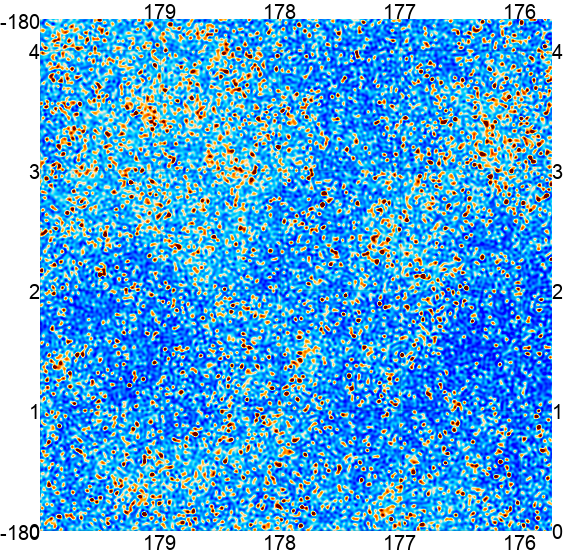

In [4]:
SEHGAL10 = sehgal.SehgalSky2010(path=sehgal_dir, data_type="healpix")
compt_idxes = ["rad_pts", "ir_pts"]
NSIDE = 8192
lmax = 10000
hparea =  hp.pixelfunc.nside2pixarea(NSIDE)

rfs = {"kappa": lambda : SEHGAL10.get_kappa(),
       "ksz": lambda : SEHGAL10.get_ksz(148),
       "tsz": lambda :SEHGAL10.get_tsz(148),
       "rad_pts": lambda :SEHGAL10.get_radio(148),
       "ir_pts": lambda :SEHGAL10.get_cib(148)
      }

flux_cuts = {"rad_pts": (1e-4, 20e-3),
             "ir_pts": (5e-3, 20e-3),
            }
take_spectra = True
show_map = True

for compt_idx in compt_idxes:
    hpmap = rfs[compt_idx]()
    loflux_cut, hiflux_cut = flux_cuts[compt_idx]
    assert(hiflux_cut >= loflux_cut)
    
    loc = np.where(np.abs(hpmap) >= hiflux_cut/hparea*sehgal.jysr2thermo(148))
    hpmap[loc] = 0
    hpmap_hi = hpmap.copy()
    loc = np.where(np.abs(hpmap_hi) <= loflux_cut/hparea*sehgal.jysr2thermo(148))
    hpmap_lo = hpmap_hi.copy()
    hpmap_hi[loc] = 0 
    hpmap_lo = hpmap-hpmap_hi

    loc = np.where(hpmap != 0)
    ntot = len(loc[0])
    loc = np.where(hpmap_hi != 0)
    nhi = len(loc[0])
    loc = np.where(hpmap_lo != 0)
    nlo = len(loc[0])
    
    print("ntot", ntot, "nhi", nhi, "nlo", nlo,)
    
    loc = np.where(hpmap_hi != 0)
    ra, dec = hp.pixelfunc.pix2ang(NSIDE, loc[0], lonlat=True)
    print(np.max(ra),np.min(ra), np.max(dec),np.min(dec))
    hiflux_cat = np.zeros((len(loc[0]),3))
    hiflux_cat[:,0] = dec*utils.degree#-np.pi/2
    hiflux_cat[:,1] = ra*utils.degree-np.pi
    hiflux_cat[:,2] = hpmap_hi[loc]*hparea

    
    del hpmap_hi
    
    alm_lo = curvedsky.map2alm_healpix(hpmap_lo, lmax=lmax)
    pmap = curvedsky.alm2map(alm_lo, template)
    ## add back high flux source
    temp = enmap.zeros(shape, wcs)
    pix = template.sky2pix(hiflux_cat[:,:2].T).T.astype(np.int)
    temp[pix[:,0], pix[:,1]] = hiflux_cat[:,2]
    temp = temp/areamap
    pmap = pmap+temp
    
    del temp, pix, hiflux_cat, hpmap_lo, alm_lo
    if take_spectra:
        alm1 = curvedsky.map2alm_healpix(hpmap, lmax=lmax)
        alm2 = curvedsky.map2alm(pmap, lmax=lmax)

        cl1 = hp.alm2cl(alm1)
        cl2 = hp.alm2cl(alm2)
        clx = hp.alm2cl(alm1,alm2)

        l = np.arange(len(cl1))
        def cl2dl(cl):
            l = np.arange(len(cl))
            l_fact = l*(l+1)/(2*np.pi)
            return l, l_fact*cl


        l, dl1 = cl2dl(cl1)
        l, dl2 = cl2dl(cl2)
        l, dlx = cl2dl(clx)
        rho = dlx/np.sqrt(dl1*dl2)

        fig = plt.figure(figsize=(12,7))
        ax = plt.gca()
        plt.plot(l,dl1, label="Healpix Original")
        plt.plot(l,dl2, label="CAR Rerpojection")
        plt.title("{} PS".format(compt_idx.upper()), fontsize=22)
        plt.legend(fontsize=22)
        plt.xlabel(r"$\ell$", fontsize=15)
        plt.ylabel(r"$D_{\ell}$", fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=22)
        ax.tick_params(axis='both', which='minor', labelsize=22)
        plt.show()

        fig = plt.figure(figsize=(12,7))
        ax = plt.gca()
        plt.plot(l,rho, label="Original x Reprojection")
        plt.xlabel(r"$\ell$", fontsize=22)
        plt.ylabel(r"$\rho$", fontsize=22)
        ax.tick_params(axis='both', which='major', labelsize=22)
        ax.tick_params(axis='both', which='minor', labelsize=22)
        plt.title("{} Correlation Coefficient".format(compt_idx.upper()), fontsize=22)
        plt.legend(fontsize=22)
        plt.ylim(0.7, 1.3)
        plt.xlim(0,lmax)
        plt.show()

    if show_map:

        stamp = pmap[ycent:ycent+512,:512]

        ftmap = enmap.fft(stamp)
        modlmap = ftmap.modlmap()
        l = modlmap.ravel()
        _, f_ell = get_f_ell(l)

        ftmap = ftmap*np.reshape(f_ell,(modlmap.shape))
        stamp_fft = enmap.ifft(ftmap).real
        
        print("Reprejecton No Beam")
        enplot.pshow(stamp)
        print("Reprojection 0.9 arcmin beam")
        enplot.pshow(stamp_fft)

    